In [78]:
import numpy as np
import matplotlib.pyplot as plt

## Task 1

In [79]:
# helper functions

#  pairwise Euclidean distance matrix
def distance_matrix(coords):
    n = len(coords)
    dist = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            d = np.linalg.norm(coords[i] - coords[j])
            dist[i, j] = d
            dist[j, i] = d
    return dist

# total length of the route
def route_length(route, dist_matrix):
    length = 0
    for i in range(len(route) - 1):
        length += dist_matrix[route[i], route[i+1]]
    return length

# swap two random stations in the route, except the first (fixed start)
def propose_swap(route):
    new_route = route.copy()
    n = len(route) - 1  # last is same as first, exclude from swap
    i, j = np.random.choice(range(1, n), size=2, replace=False)
    new_route[i], new_route[j] = new_route[j], new_route[i]
    return new_route

# type of cooling scheme, methods proposed in exercises
def cooling_schedule(k, method="sqrt"):
    if method == "sqrt":
        return 1 / np.sqrt(k + 1)
    elif method == "log":
        return -np.log(k + 1) if k > 0 else 1
    else:
        return 1 / np.sqrt(k + 1)  # default
    
def plot_route(coords, route):
    plt.figure(figsize=(8, 8))
    plt.plot(coords[route, 0], coords[route, 1], 'o-', color='blue', markersize=8)
    plt.plot(coords[route[0], 0], coords[route[0], 1], 'ro', markersize=12)  # start/end in red
    plt.title("TSP route found by simulated annealing")
    plt.xlabel("X coordinate")
    plt.ylabel("Y coordinate")
    plt.grid(True)
    plt.show()

In [80]:
def simulated_annealing_tsp(coords, iterations=10000, cooling="sqrt"):
    n = len(coords)
    dist_matrix = distance_matrix(coords)
    
    # initial state: random permutation except fixed start/end
    route = np.arange(n)
    np.random.shuffle(route[1:])
    route = np.append(route, route[0])  # end where started
    
    current_length = route_length(route, dist_matrix)
    
    for k in range(iterations):
        T = cooling_schedule(k, method=cooling)
        candidate_route = propose_swap(route)
        candidate_length = route_length(candidate_route, dist_matrix)
        
        delta = candidate_length - current_length
        
        # MH-step:
        # accept if candidate has lower energy than old state, and also accept w prob
        if delta < 0 or np.random.rand() < np.exp(-delta / T):
            route = candidate_route
            current_length = candidate_length
        
        if k % 1000 == 0:
            print(f"Iteration {k}, Temperature {T:.4f}, Route length {current_length:.4f}")
    
    return route, current_length

Iteration 0, Temperature 1.0000, Route length 11.9211
Iteration 1000, Temperature 0.0316, Route length 5.0096
Iteration 2000, Temperature 0.0224, Route length 4.9004
Iteration 3000, Temperature 0.0183, Route length 4.9004
Iteration 4000, Temperature 0.0158, Route length 4.9004
Iteration 5000, Temperature 0.0141, Route length 4.9413
Iteration 6000, Temperature 0.0129, Route length 4.9212
Iteration 7000, Temperature 0.0120, Route length 4.9004
Iteration 8000, Temperature 0.0112, Route length 4.9212
Iteration 9000, Temperature 0.0105, Route length 4.9004
Best route found: [ 0 10 15 19  8  4 11  3 17  5  7  1  9 14 12  2 18 13  6 16  0]
Best route length: 4.900372059391176


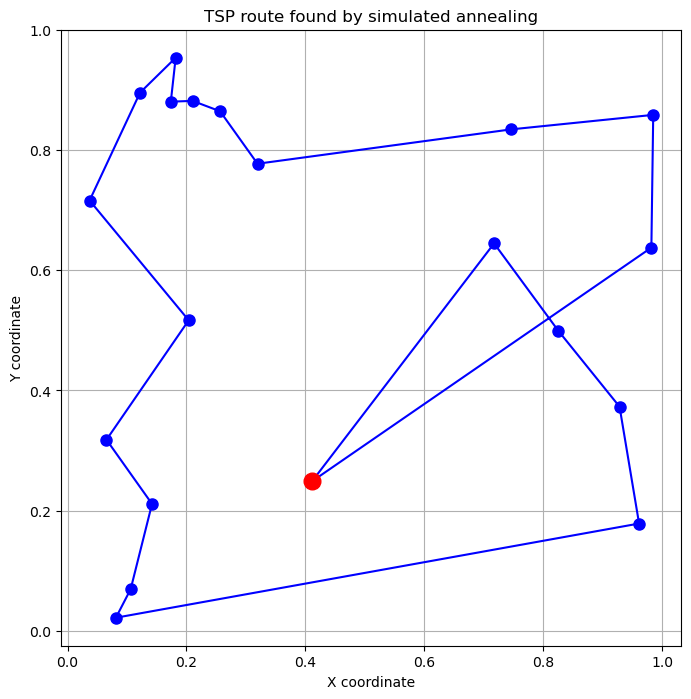

In [81]:
# random 2D coordinates for stations
stations = np.random.rand(20, 2)
    
best_route, best_length = simulated_annealing_tsp(stations)
print("Best route found:", best_route)
print("Best route length:", best_length)
plot_route(stations, best_route)

Modifyed for cost matrix

In [82]:
cost_matrix_str = """
0,225,110,8,257,22,83,231,277,243,94,30,4,265,274,250,87,83,271,86
255,0,265,248,103,280,236,91,3,87,274,265,236,8,24,95,247,259,28,259
87,236,0,95,248,110,25,274,250,271,9,244,83,250,248,280,29,26,239,7
8,280,83,0,236,28,91,239,280,259,103,23,6,280,244,259,95,87,230,84
268,87,239,271,0,244,275,9,84,25,244,239,275,83,110,24,274,280,84,274
21,265,99,29,259,0,99,230,265,271,87,5,22,239,236,250,87,95,271,91
95,236,28,91,247,93,0,247,259,244,27,91,87,268,275,280,7,8,240,27
280,83,250,261,4,239,230,0,103,24,239,261,271,95,87,21,274,255,110,280
247,9,280,274,84,255,259,99,0,87,255,274,280,3,27,83,259,244,28,274
230,103,268,275,23,244,264,28,83,0,268,275,261,91,95,8,277,261,84,247
87,239,9,103,261,110,29,255,239,261,0,259,84,239,261,242,24,25,242,5
30,255,95,30,247,4,87,274,242,255,99,0,24,280,274,259,91,83,247,91
8,261,83,6,255,29,103,261,247,242,110,29,0,261,244,230,87,84,280,100
242,8,259,280,99,242,244,99,3,84,280,236,259,0,27,95,274,261,24,268
274,22,250,236,83,261,247,103,22,91,250,236,261,25,0,103,255,261,5,247
244,91,261,255,28,236,261,29,103,9,242,261,244,87,110,0,242,236,95,259
84,236,27,99,230,83,7,259,230,230,22,87,93,250,255,247,0,9,259,24
91,242,28,87,250,110,6,271,271,255,27,103,84,250,271,244,5,0,271,29
261,24,250,271,84,255,261,87,28,110,250,248,248,22,3,103,271,248,0,236
103,271,8,91,255,91,21,271,236,271,7,250,83,247,250,271,22,27,248,0
"""

cost_matrix = np.array([list(map(int, line.split(','))) for line in cost_matrix_str.strip().split('\n')])


In [83]:
def simulated_annealing_tsp(cost_matrix, iterations=10000, cooling="sqrt"):
    n = len(cost_matrix) 
    # remove dist_matrix

    # initial state: random permutation except fixed start/end
    route = np.arange(n)
    np.random.shuffle(route[1:])
    route = np.append(route, route[0])  # end where started
    
    current_length = route_length(route, cost_matrix)
    
    for k in range(iterations):
        T = cooling_schedule(k, method=cooling)
        candidate_route = propose_swap(route)
        candidate_length = route_length(candidate_route, cost_matrix) # take cost_matrix as arg for candidate length
        
        delta = candidate_length - current_length
        
        if delta < 0 or np.random.rand() < np.exp(-delta / T):
            route = candidate_route
            current_length = candidate_length
        
        if k % 1000 == 0:
            print(f"Iteration {k}, Temperature {T:.4f}, Route length {current_length:.4f}")
    
    return route, current_length

In [96]:
best_route, best_length = simulated_annealing_tsp(cost_matrix, iterations=30000, cooling="sqrt")
print("Best route found:", best_route)
print("Best route length:", best_length)

Iteration 0, Temperature 1.0000, Route length 3630.0000
Iteration 1000, Temperature 0.0316, Route length 831.0000
Iteration 2000, Temperature 0.0224, Route length 825.0000
Iteration 3000, Temperature 0.0183, Route length 825.0000
Iteration 4000, Temperature 0.0158, Route length 825.0000
Iteration 5000, Temperature 0.0141, Route length 825.0000
Iteration 6000, Temperature 0.0129, Route length 825.0000
Iteration 7000, Temperature 0.0120, Route length 825.0000
Iteration 8000, Temperature 0.0112, Route length 825.0000
Iteration 9000, Temperature 0.0105, Route length 825.0000
Iteration 10000, Temperature 0.0100, Route length 825.0000
Iteration 11000, Temperature 0.0095, Route length 825.0000
Iteration 12000, Temperature 0.0091, Route length 825.0000
Iteration 13000, Temperature 0.0088, Route length 825.0000
Iteration 14000, Temperature 0.0085, Route length 825.0000
Iteration 15000, Temperature 0.0082, Route length 825.0000
Iteration 16000, Temperature 0.0079, Route length 825.0000
Iteration